## PyTorch Tutorial


M Sdika

Adapted from

    https://github.com/mila-udem/welcome_tutorials/tree/master/pytorch



## Classifying MNIST & CIFAR-10 with Convnets & ResNets

In [1]:
import time
import numpy as np


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F


In [3]:
import torchvision
import torchvision.transforms

In [4]:
import matplotlib.pyplot as plt

In [5]:
def count_parameters(model):
    #for parameter in model.parameters():
    #    print(parameter)
    #print ('nb of trainable parameters')
    return (sum([p.numel() for p in model.parameters() if p.requires_grad]))


### Define image transformations &  Initialize datasets

In [6]:
# downsample image for speed
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((28,28), interpolation=2), torchvision.transforms.ToTensor()])

mnist_train0     = torchvision.datasets.MNIST(root='../data', train=True,  transform=mnist_transforms, download=True)
mnist_test       = torchvision.datasets.MNIST(root='../data', train=False, transform=mnist_transforms, download=True)

print (mnist_train0)

# subsample dataset for speed
# to be removed.... and replaced by torch.utils.data.Subset
class Subset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]
    def __len__(self):
        return len(self.indices)
mnist_train = Subset(mnist_train0, range(0,len(mnist_train0),10))   

print('Reduced Dataset')
print('Number of samples: ', len(mnist_train))
img, target = mnist_train[3] # load 4th sample
print(img.min())
print(img.max())


print("Image Size: ", img.size())
print(target)





Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Reduced Dataset
Number of samples:  6000
tensor(0.)
tensor(1.)
Image Size:  torch.Size([1, 28, 28])
3


/home/conda/miniconda3/envs/cuda11/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


### PLOT SOME RANDOM DIGITS

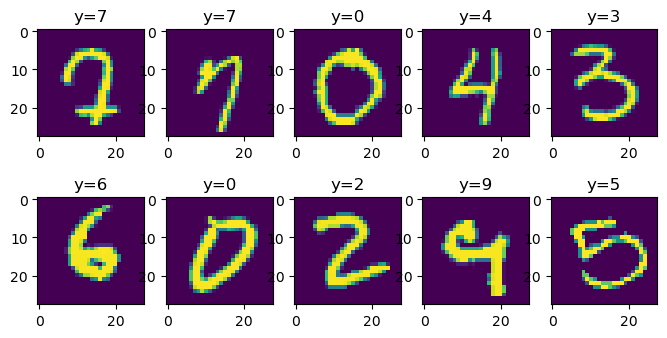

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 4), squeeze=False)

for i in range(10):
    r = i // 5
    c = i % 5
    idx = np.random.choice(len(mnist_train), 1)[0]
    x = mnist_train[idx][0].numpy()
    y = mnist_train[idx][1]
    axes[r, c].imshow(x[0, :, :])
    axes[r, c].set_title('y={}'.format(y))
    
plt.show()

### Create multi-threaded DataLoaders

In [8]:
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
testloader  = torch.utils.data.DataLoader(mnist_test,  batch_size=64, shuffle=True, num_workers=2)

# Main classifier that subclasses nn.Module

implements:
1. multi layer perceptron
2. convolutional neural network
3. a convolutional neural network with convolution layers only (implement FC with conv)
4. residual network

Try to improve accuracy

Play with the following paramèters:
- lr initialization
- epochs
- train_batch_size
- More hidden layers
- Convolutions + max pooling
- Dropout
- Residual layers
- changer l'algorithme de descente de gradient (Adam)
- implement early stopping
- lr scheduling



#### Multi Layer Perceptron

In [9]:
class MLPNet(nn.Module):
    def __init__(self,s):
        super(MLPNet, self).__init__()
        self.name = 'mlp'
        self.s    = s
        self.fc1  = nn.Linear(int(np.prod(s)), 10)

    def forward(self, x):
        x = x.view(-1, int(np.prod(self.s)))  # flatten images
        x = self.fc1(x)
        return (x)

# TODO

class MLPNet2(nn.Module):
    def __init__(self,s):
        super(MLPNet2, self).__init__()
        self.name = 'mlpnet2'
        self.s    = s
        self.fc1  = nn.Linear(int(np.prod(s)), 100)
        self.fc2  = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, int(np.prod(self.s)))  # flatten images
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return (x)


#### Convolutional Neural Network

In [10]:
class ConvNet(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(ConvNet,self).__init__()
        self.name = 'CNN1'
        self.conv = 1 # nn.Sequential(.....)

        # Logistic Regression
        self.fc = nn.Linear(128, 10) # change dimensions

    def forward(self, x):
        # conv
        # flatten
        # linear
        return ...
    
    
    
    
    

class ResBlock(nn.Module):
    expansion = 1
    def __init__(self, nchannel):
        super(ResBlock, self).__init__()
        
    def forward(self, x):
        return x
    
    
    
class ResNet(nn.Module):

    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.name    = 'resnet'
        
    def forward(self, x):
        return x

    

In [11]:
## initialize the network parameters

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        #print(m)
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out')
            #if m.bias:
            #init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, std=1e-3)
            #if m.bias:
            init.constant_(m.bias, 0) 

In [12]:
if torch.cuda.is_available():
    print('use cuda')
    device = torch.device('cuda')
else:
    print('use CPU')
    device = torch.device('cpu')

use cuda


In [13]:
dlossesTR    = {}
dlossesTRAll = {}
dlossesTE    = {}
didxEpoch    = {}
dbestAcc     = {}
dnbParam     = {}

In [21]:
s = mnist_train[0][0].size()

net = MLPNet(s)
#net = ConvNet()
#net = ResNet()

# randon init of the network weight
init_params(net)


lr0 = 1e-5

test_name = net.name + '_lr0_' + "{:.1e}".format(lr0)
print(test_name)

# transfer the network on gpu if avalaible
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr0)
criterion = nn.CrossEntropyLoss()

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
lr_step  = 5
lr_gamma = 0.1


mlp_lr0_1.0e-05


In [22]:
# to store losses for all epochs / iterations
lossesTR    = []
lossesTRAll = []
lossesTE    = []
idxEpoch    = [0]
bestAcc     = 0

# iterate for each epoch
for epoch in range(20):
    # potentially decrease lr 
    # scheduler.step()
    lr = lr0 * lr_gamma**int(epoch/lr_step)
    optimizer.lr = lr
    print (lr)
    
    losses = []
    # Train : 1 epoch <-> loop once one the entire training dataset
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        #if cuda_available:
        #    inputs, targets = inputs.cuda(), targets.cuda()
        # transfer to GPU if avalaible
        inputs, targets = inputs.to(device), targets.to(device)

        
        # clear gradient    
        optimizer.zero_grad()
        
        # convert input to Variable
        #inputs, targets = Variable(inputs), Variable(targets)
        
        # compute the output of the network for the given inputs
        outputs = net(inputs)
        
        # compute the loss function
        loss = criterion(outputs, targets)
        
        # compute the gradient w.r. to all weights 
        loss.backward()
        
        # one update of the parameter update
        optimizer.step()
        
        # store loss of the current iterate
        losses.append(loss.data.item())
        lossesTRAll.append(loss.data.item())
    
    end = time.time()
    # meanlosses = torch.mean(torch.stack(losses)) 
    lossesTR.append(np.mean(losses))
    idxEpoch.append(idxEpoch[-1] + len(losses))
    print('Epoch : %d Train Loss : %.3f         time: %.3f' % (epoch, np.mean(losses),end-start))
    
    # Evaluate the current network on the validation dataset
    net.eval()
    total = 0
    correct = 0
    losses = []
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # transfer to GPU if avalaible
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.data.item())
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    end = time.time()
    lossesTE.append(np.mean(losses))
    

    bestAcc = max(bestAcc,100.*correct/total)
    print('Epoch : %d Test Loss  : %.3f        Test Acc %.3f       time: %.3f' % (epoch, np.mean(losses),100.*correct/total,end-start))
    print('--------------------------------------------------------------')
    net.train()

1e-05
Epoch : 0 Train Loss : 2.285         time: 0.391
Epoch : 0 Test Loss  : 2.267        Test Acc 55.570       time: 0.585
--------------------------------------------------------------
1e-05
Epoch : 1 Train Loss : 2.253         time: 0.403
Epoch : 1 Test Loss  : 2.234        Test Acc 65.640       time: 0.609
--------------------------------------------------------------
1e-05
Epoch : 2 Train Loss : 2.221         time: 0.401
Epoch : 2 Test Loss  : 2.202        Test Acc 69.710       time: 0.617
--------------------------------------------------------------
1e-05
Epoch : 3 Train Loss : 2.190         time: 0.425
Epoch : 3 Test Loss  : 2.170        Test Acc 70.770       time: 0.599
--------------------------------------------------------------
1e-05
Epoch : 4 Train Loss : 2.160         time: 0.402
Epoch : 4 Test Loss  : 2.140        Test Acc 71.920       time: 0.596
--------------------------------------------------------------
1.0000000000000002e-06
Epoch : 5 Train Loss : 2.130         

### plot learning curves

----------------------------------------------------------------------------
----------------------------------------------------------------------------
----------------------------------------------------------------------------
mlp_lr0_1.0e-01
best accuracy      : 88.4000015258789
best loss on train : 0.3824855815222923 idx 16
best loss on test  : 0.9924431437519705 idx 1
n param            : 7850


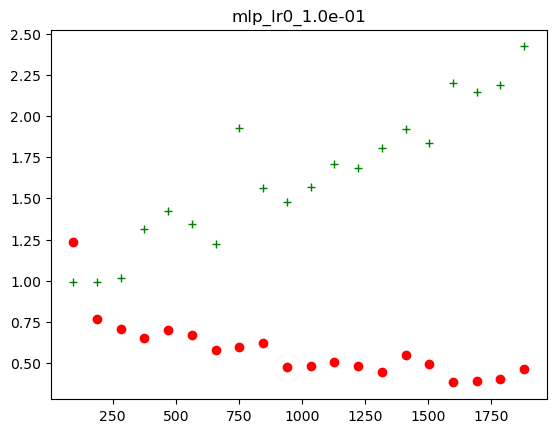

----------------------------------------------------------------------------
----------------------------------------------------------------------------
----------------------------------------------------------------------------
mlp_lr0_1.0e-03
best accuracy      : 89.94000244140625
best loss on train : 0.2727394826868747 idx 19
best loss on test  : 0.3570447930010261 idx 19
n param            : 7850


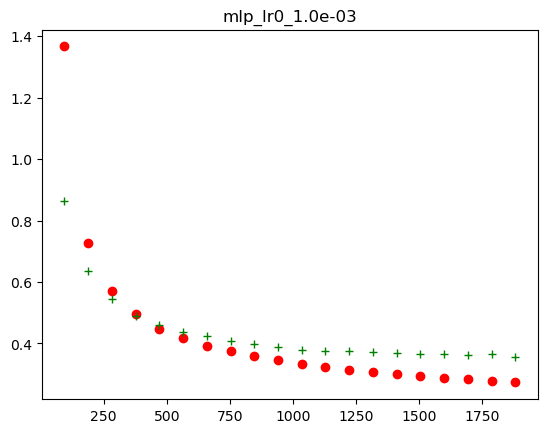

----------------------------------------------------------------------------
----------------------------------------------------------------------------
----------------------------------------------------------------------------
mlp_lr0_1.0e-05
best accuracy      : 77.05000305175781
best loss on train : 1.76842344948586 idx 19
best loss on test  : 1.742839212630205 idx 19
n param            : 7850


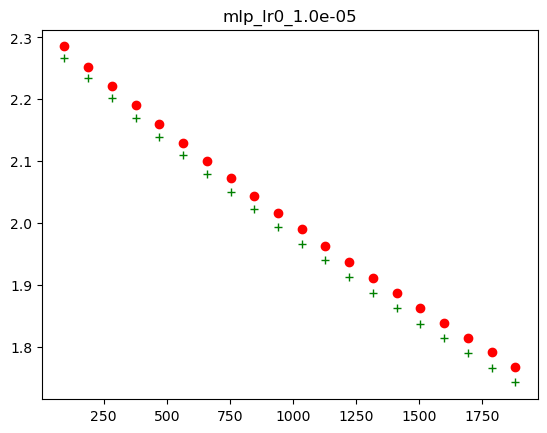

In [25]:
# to store losses for all epochs / iterations
lossesTR
dlossesTR[test_name]    = lossesTR
dlossesTRAll[test_name] = lossesTRAll
dlossesTE[test_name]    = lossesTE
didxEpoch[test_name]    = idxEpoch
dbestAcc[test_name]     = bestAcc
dnbParam[test_name]     = count_parameters(net)

#for n in ['convnet', 'CNN2']:
for n in [ 'mlp_lr0_1.0e-01', 'mlp_lr0_1.0e-03', 'mlp_lr0_1.0e-05' ]: # ajouter dans cette liste le nom des reseaux que vous tester 
    if n in dlossesTR:
        print ('----------------------------------------------------------------------------')
        print ('----------------------------------------------------------------------------')
        print ('----------------------------------------------------------------------------')
        print (n)
        print ('best accuracy      : '+str(dbestAcc[n].item()))
        print ('best loss on train : '+str(np.min(dlossesTR[n])) + ' idx '+str(np.argmin(dlossesTR[n])))
        print ('best loss on test  : '+str(np.min(dlossesTE[n])) + ' idx '+str(np.argmin(dlossesTE[n])))
        print ('n param            : '+str(dnbParam[n]))

        # evenly sampled time at 200ms intervals
        t = np.arange(0, len(dlossesTRAll[n]))

        plt.plot(didxEpoch[n][1:], dlossesTR[n], 'ro', didxEpoch[n][1:], dlossesTE[n], 'g+')
#        plt.plot(t, dlossesTRAll[n], 'b', didxEpoch[n][1:], dlossesTR[n], 'ro', didxEpoch[n][1:], dlossesTE[n], 'gs')
        plt.title(n)
        plt.show()